<a href="https://colab.research.google.com/github/CSID-DGU/2021-1-OSSP1-Debugger-4/blob/autoencoder/CNN_AUTOENCODER_ver1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1rsFeNH-ldl3-UCjRoEMUtuxPekRjTEgu?usp=sharing)

In [ ]:
from google.colab import drive #구글드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라이브러리 설정
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import gc
import glob
from tensorflow.keras.layers import Reshape

# 랜덤 시드 고정
SEED=2021
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# **안경 미착용 Dataset**

In [ ]:
import sys, os

num = 0
index = []
for a in range(100):
  for i in range(1): #S001만
    #print('S' + str(i + 1))
    for j in range(4): #L1-L4
      #print('L' + str(j + 1))
      for k in range(2): #E1-E2
        #print('E' + str(k + 1))
        for x in range(7): #C달고있는 12개 중 7개만
          index.append(num)
          num = num + 1
        num = num + 5
    num = num + 336  
print(len(index))
print(index)

rootpath = ['./drive/MyDrive/A_Complete', './drive/MyDrive/B_complete', './drive/MyDrive/C_Complete', './drive/MyDrive/D_Complete']
filename = ['/A_', '/B_', '/A_', '/D_']

filepath = []

for i in range(4):
  temp = rootpath[i] + filename[i]
  for j in range(len(index)):
    path = temp + str(index[j]) + '.jpg'
    filepath.append(path)

print(len(filepath))

5600
[0, 1, 2, 3, 4, 5, 6, 12, 13, 14, 15, 16, 17, 18, 24, 25, 26, 27, 28, 29, 30, 36, 37, 38, 39, 40, 41, 42, 48, 49, 50, 51, 52, 53, 54, 60, 61, 62, 63, 64, 65, 66, 72, 73, 74, 75, 76, 77, 78, 84, 85, 86, 87, 88, 89, 90, 432, 433, 434, 435, 436, 437, 438, 444, 445, 446, 447, 448, 449, 450, 456, 457, 458, 459, 460, 461, 462, 468, 469, 470, 471, 472, 473, 474, 480, 481, 482, 483, 484, 485, 486, 492, 493, 494, 495, 496, 497, 498, 504, 505, 506, 507, 508, 509, 510, 516, 517, 518, 519, 520, 521, 522, 864, 865, 866, 867, 868, 869, 870, 876, 877, 878, 879, 880, 881, 882, 888, 889, 890, 891, 892, 893, 894, 900, 901, 902, 903, 904, 905, 906, 912, 913, 914, 915, 916, 917, 918, 924, 925, 926, 927, 928, 929, 930, 936, 937, 938, 939, 940, 941, 942, 948, 949, 950, 951, 952, 953, 954, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1356, 1

In [ ]:
!pip install pyturbojpeg  

from turbojpeg import TurboJPEG
jpeg = TurboJPEG()

train_y = []
train_test = []

for _ in range(0,len(filepath)):
  print(_)
  try:
    in_file = open(filepath[_], 'rb')
    img = jpeg.decode(in_file.read(),0)
    in_file.close()
    train_y.append(img.astype("float32")/255.0)
  except:
    print(filepath[_])


Y_1 = np.array(train_y)

np.savez_compressed(f'./drive/MyDrive/dataSet_Non', Y_1)
print(Y_1.shape)





# **안경 착용 Dataset** 

In [ ]:
num = 0
index = []
for a in range(100):
  for i in range(1): #S002만
    #print('S' + str(i + 1))
    for j in range(4): #L1-L4
      #print('L' + str(j + 1))
      for k in range(2): #E1-E2
        #print('E' + str(k + 1))
        for x in range(7): #C달고있는 12개 중 7개만
          index.append(num)
          num = num + 1
        num = num + 5
    num = num + 336

index = [i+144 for i in index]
print(len(index))
print(index)

rootpath = ['./drive/MyDrive/A_Complete', './drive/MyDrive/B_complete', './drive/MyDrive/C_Complete', './drive/MyDrive/D_Complete']
filename = ['/A_', '/B_', '/A_', '/D_']

filepath = []

for i in range(4):
  temp = rootpath[i] + filename[i]
  for j in range(len(index)):
    path = temp + str(index[j]) + '.jpg'
    filepath.append(path)

print(len(filepath))

In [ ]:
!pip install pyturbojpeg  

from turbojpeg import TurboJPEG
jpeg = TurboJPEG()

train_y = []
train_test = []

for _ in range(0,len(filepath)):
  if _%500 == 0:
    print(_)
  try:
    in_file = open(filepath[_], 'rb')
    img = jpeg.decode(in_file.read(),0)
    in_file.close()
    train_y.append(img.astype("float32")/255.0)
  except:
    print(filepath[_])


Y_1 = np.array(train_y)

np.savez_compressed(f'./drive/MyDrive/dataSet_glasses', Y_1)
print(Y_1.shape)


In [ ]:
import random
load_y=np.load('./drive/MyDrive/dataSet_Non.npz')  #이미지 데이터가 저장된 NPZ 로드하기.
Y_1 =load_y['arr_0']
load_y.close()
np.random.shuffle(Y_1)
Y_1 = Y_1[:-1000]    
Y_test = Y_1[-1000:] 

del load_y
print(Y_1.shape)
gc.collect()

(21020, 128, 128, 3)


15

In [ ]:
#팀장 데이터 불러오기 (Pre-Trained Model에 추가학습용) -> 동영상 프레임 추출 사진
minsu = glob.glob('./drive/MyDrive/videoimage3/*.png')
test_minsu = []
for _ in range(0,100):
  img = cv2.imread(minsu[int(_*1.5)])
  img = cv2.resize(img,(128,128))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  test_minsu.append(img.astype("float32")/255.0)
  
test_minsu = np.array(test_minsu)

print(test_minsu.shape)

(100, 128, 128, 3)


In [ ]:
#실제 합성된 사진 테스트용 코드
real_test = glob.glob('./*.png')
real = []
img=cv2.imread(real_test[0])
img = cv2.resize(img,(128,128))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
real.append(img.astype("float32")/255.0)


img=cv2.imread(real_test[1])
img = cv2.resize(img,(128,128))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
real.append(img.astype("float32")/255.0)
  
real = np.array(real)

print(real.shape)

(2, 128, 128, 3)


In [ ]:
# 오토인코더 모델 정의
def Autoencoder():

  X = tf.keras.layers.Input(shape=[128,128,3])

  #Encoder (Convolution layer 4겹)
  H = tf.keras.layers.Conv2D(32,(4,4),(2,2),activation='relu',padding='same')(X)
  H = tf.keras.layers.Conv2D(32*2,(4,4), (2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*4, (4,4),(2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*8, (4,4),(2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*16, (4,4),(2,2),activation='relu',padding='same')(H)

 

  pool_tmp = H.shape.as_list()
  pool_tmp=pool_tmp[1:]
  
  #Fully-Connected
  H = tf.keras.layers.Flatten()(H)
  flatten_tmp=H.shape.as_list()
  flatten_tmp=flatten_tmp[1]
 
  H = tf.keras.layers.Dense(4086,activation='relu')(H)
  H = tf.keras.layers.Dense(flatten_tmp,activation='relu')(H)
  H = Reshape(pool_tmp)(H)


  #Decoder
  
  H = tf.keras.layers.Conv2DTranspose(32*8,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32*4,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32*2,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(3,(2,2),strides=(2,2),padding='same',activation='relu')(H)

  model = tf.keras.models.Model(X,H)
  model.compile(optimizer='adam',loss='mean_squared_error', metrics=['acc']) #MSLE Loss Funciton 적용

  return model

ae_model = Autoencoder()
ae_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        1568      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         524544    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 512)         2097664   
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0     

In [ ]:
#모델 체크포인트 설정
checkpoint_path = 'checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only = True,
                                                save_best_only = True,
                                                monitor='val_acc',
                                                verbose=1)

In [ ]:
# 오토인코더 모델 학습
history = ae_model.fit(Y_1,
                      Y_1,
                       batch_size=50, #한번에 학습할 데이터 Batch_size
                       epochs=50,      #에포크 설정
                       verbose=1,      #학습과정 시각화                       
                       callbacks=[checkpoint],  #모델 체크포인트 저장
                       validation_split=0.2)    #Validation_data는 20%


                      


Epoch 1/50
337/337 [==============================] - 11s 32ms/step - loss: 0.0011 - acc: 0.8923 - val_loss: 0.0013 - val_acc: 0.8924

Epoch 00001: val_acc did not improve from 0.89335
Epoch 2/50
337/337 [==============================] - 10s 30ms/step - loss: 0.0011 - acc: 0.8962 - val_loss: 0.0014 - val_acc: 0.8911

Epoch 00002: val_acc did not improve from 0.89335
Epoch 3/50
337/337 [==============================] - 10s 30ms/step - loss: 0.0011 - acc: 0.8938 - val_loss: 0.0013 - val_acc: 0.8931

Epoch 00003: val_acc did not improve from 0.89335
Epoch 4/50
337/337 [==============================] - 10s 30ms/step - loss: 0.0011 - acc: 0.8954 - val_loss: 0.0014 - val_acc: 0.8930

Epoch 00004: val_acc did not improve from 0.89335
Epoch 5/50
337/337 [==============================] - 10s 30ms/step - loss: 0.0011 - acc: 0.8957 - val_loss: 0.0028 - val_acc: 0.8823

Epoch 00005: val_acc did not improve from 0.89335
Epoch 6/50
337/337 [==============================] - 10s 30ms/step - loss:

In [ ]:
ae_images = ae_model.predict(test_minsu) #전이학습 평가
ae_images.shape

(100, 128, 128, 3)

In [ ]:
ae_images = ae_model.predict(real)  #최종 목표 합성물 평가
ae_images.shape

(2, 128, 128, 3)

In [ ]:
ae_images = ae_model.predict(Y_test)  #Pre-trained Model 평가용
ae_images.shape

(1000, 128, 128, 3)

In [ ]:
#이미지 출력
num = 10 
plt.figure(figsize=(20,8))
for i in range(10):
    # 원본 이미지
    ax = plt.subplot(2, num, i+1)
    plt.imshow(real[i])
    plt.title("Original %s" % str(i))
    plt.axis('off')
    
    # 복원 이미지
    ax = plt.subplot(2, num, i+num+1)
    plt.imshow(ae_images[i])
    plt.title("Auto-encoded %s" % str(i))
    plt.axis('off')
    
plt.show()

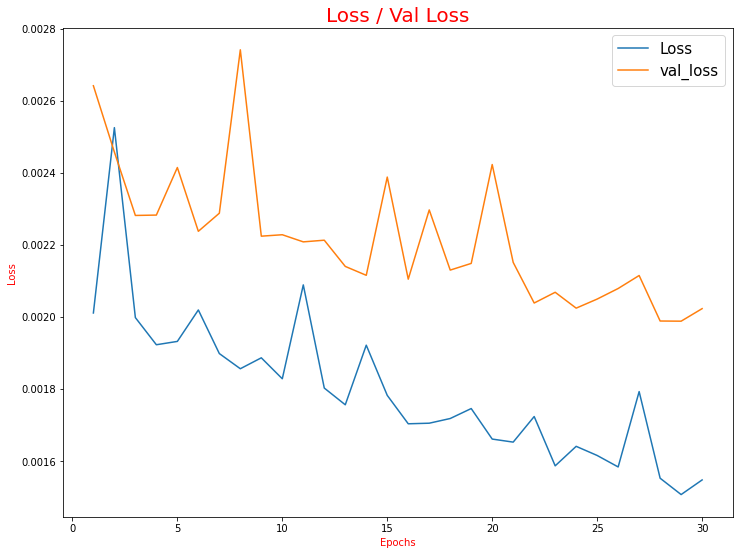

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(np.arange(1,len(history.history['loss'])+1), history.history['loss'])
plt.plot(np.arange(1,len(history.history['val_loss'])+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20, color='red')
plt.xlabel('Epochs', color='red')
plt.ylabel('Loss',color='red')
plt.legend(['Loss', 'val_loss'], fontsize=15)
plt.show()